In [1]:
import pandas as pd
from pandas import Timestamp
from pandas.tseries.offsets import BDay
import numpy as np
from scipy.interpolate import interp1d
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

# 1. Change directory to raw data folder

In [2]:
# Get the current working directory
current_directory = os.getcwd()

# Get the parent directory by going one level up
parent_directory = os.path.dirname(current_directory)

# Get the path of raw data folder
data_raw_folder = os.path.join(parent_directory, 'data/raw')

# Change the current working directory to raw data folder
os.chdir(data_raw_folder)

# 2. Import datasets

In [3]:
# New issues data
new_issues = pd.read_csv('new_issues.csv', index_col=0)
new_issues_characteristics =  pd.read_csv('new_issues_characteristics.csv', index_col=0)
new_issues_prices_refinitive_ask =  pd.read_csv('new_issues_prices_askyield_refinitive.csv', index_col=0)
swap_rates = pd.read_csv('swap_rates.csv', index_col=0)

In [4]:
# Comparable bonds data
chunk_dfs = []
for i in range(6):
    chunk_df = pd.read_csv(f'comparable_bonds_peers_duration_iboxx_{i+1}.csv', index_col=0)
    chunk_dfs.append(chunk_df)

comparable_bonds_iboxx = pd.concat(chunk_dfs, ignore_index=True)

In [5]:
# Index data
iboxx_indices = pd.read_csv('iboxx_indices.csv', sep=';')
move_index = pd.read_csv('move_index.csv')

# 3. Modify raw datasets and create subsets

## 3.1 New issues

In [6]:
# Create new issues dataframe with selected columns
new_issues_sliced = new_issues.loc[:,['securities_isin', 'ticker', 'dealDate',
                                      'issuerType', 'paymentType', 'countryName', 'COUNTRY_ISO_CODE', 
                                      'moodys', 'sp', 'fitch', 'expectedSize', 'actualSize', 'minimumDenomination', 
                                      'securityType', 'maturityTerm', 'coupon', 'seniority_name_1', 
                                      'seniority_name_1_adj', 'esgType', 'referenceType', 'ipt_reference',
                                      'ipt_price_down', 'ipt_price_up', 'guidance_reference', 'guidance_price_down',
                                      'guidance_price_up', 'launchValue', 'reofferValue', 'yieldToMaturity', 'duration',
                                     'Industry_Group', 'Industry_Sector']]

# Change time type
new_issues_sliced['dealDate'] = pd.to_datetime(new_issues_sliced['dealDate'])
new_issues_sliced['dealDate'] = new_issues_sliced['dealDate'].dt.floor('d')

In [7]:
# Deal with duplicated isins

# Sort the DataFrame by 'dealDate' in ascending order
new_issues_sliced = new_issues_sliced.sort_values('dealDate')

# Keep the first occurrence of each ISIN
new_issues_sliced = new_issues_sliced.drop_duplicates('securities_isin', keep='first')

## 3.2 Comparable bonds

In [8]:
# Change time type
comparable_bonds_iboxx['date'] = pd.to_datetime(comparable_bonds_iboxx['date'])
comparable_bonds_iboxx['date'] = comparable_bonds_iboxx['date'].dt.floor('d')

In [9]:
# Rename column
comparable_bonds_iboxx = comparable_bonds_iboxx.rename(columns={'new_issue_isin': 'isin', 'ticker': 'tickerCompBond'})

## 3.3 New issues characteristics; New issues prices

In [10]:
# Merge new issues with corresponding payment ranks
new_issues_sliced = new_issues_sliced.merge(new_issues_characteristics[['security', 'PAYMENT_RANK']], left_on = 'securities_isin', right_on = 'security', how = 'inner')
new_issues_sliced = new_issues_sliced.drop(['security'], axis=1)

In [11]:
# Change time type in refinitive prices dataset
new_issues_prices_refinitive_ask['Date'] = pd.to_datetime(new_issues_prices_refinitive_ask['Date'])
new_issues_prices_refinitive_ask['Date'] = new_issues_prices_refinitive_ask['Date'].dt.date
new_issues_prices_refinitive_ask['Date'] = new_issues_prices_refinitive_ask['Date'].astype('datetime64')
new_issues_prices_refinitive_ask['Date'] = new_issues_prices_refinitive_ask['Date'].dt.floor('d')

In [12]:
# Filter out 'wrong' prices (EUR price instead of yield)
new_issues_prices_refinitive = new_issues_prices_refinitive_ask[(abs(new_issues_prices_refinitive_ask['Ask Yield']) < 10) | (new_issues_prices_refinitive_ask['Ask Yield'].isna())]

## 3.4 Iboxx indices

In [13]:
# Change time type in iboxx index dataset
iboxx_indices['Download_Date'] = pd.to_datetime(iboxx_indices['Download_Date'])

In [14]:
# Create issue dataframe with selected columns
iboxx_indices_sliced = iboxx_indices.loc[:,['Download_Date', 'Name', 'Annual_Yield_to_Maturity', 'Expected_Remaining_Life']]

In [15]:
# Keep only iBoxx € Corporates Senior and iBoxx € Financials Senior
iboxx_indices_sliced = iboxx_indices_sliced[iboxx_indices_sliced['Name'].isin(['iBoxx € Corporates Senior', 'iBoxx € Financials Senior'])]

## 3.5 Swap rates

In [16]:
# Extract the column names and their corresponding years
columns = swap_rates.columns
years = []

# Determine if the column represents months or years and extract the corresponding number
for col in columns:
    match = re.search(r'(\d+)([YM])=', col)
    if match:
        num = int(match.group(1))
        unit = match.group(2)
        if unit == 'Y':
            years.append(num)
        elif unit == 'M':
            years.append(num / 12)
            
# Create a dictionary to map the old column names to the new column names
new_columns = {col: yr for col, yr in zip(columns, years)}

# Rename the columns in the DataFrame
swap_rates.rename(columns=new_columns, inplace=True)

# Sort the columns in ascending order
swap_rates = swap_rates.reindex(sorted(swap_rates.columns), axis=1)

# Change time type in refinitive prices dataset
swap_rates = swap_rates.reset_index()
swap_rates['Date'] = pd.to_datetime(swap_rates['Date'])
swap_rates['Date'] = swap_rates['Date'].dt.date
swap_rates['Date'] = swap_rates['Date'].astype('datetime64')
swap_rates['Date'] = swap_rates['Date'].dt.floor('d')
swap_rates = swap_rates.set_index('Date')

In [17]:
# Extract the maturities from column names
maturities = [col for col in swap_rates.columns]

# Interpolate the swap rate curve for each timestamp
interpolated_swap_rates = {}
for timestamp, row in swap_rates.iterrows():
    swap_rate_interpolator = interp1d(maturities, row, kind='cubic')
    interpolated_swap_rates[timestamp] = swap_rate_interpolator

## 3.6 Create dataframe of initial MS of new issues

In [18]:
# MS spread from IPREO data
new_issues_yield_ipreo = new_issues_sliced.loc[:, ['dealDate', 'securities_isin', 'ticker', 'maturityTerm', 'duration', 'PAYMENT_RANK', 'issuerType', 'reofferValue']]
new_issues_yield_ipreo = new_issues_yield_ipreo.rename(columns={'securities_isin': 'isin'})
new_issues_yield_ipreo = new_issues_yield_ipreo.drop_duplicates()

In [19]:
# Keep new issues with known initial MS
new_issues_initial_prices = new_issues_yield_ipreo.loc[~new_issues_yield_ipreo['reofferValue'].isna(), :]

In [20]:
new_issues_initial_prices = new_issues_initial_prices.reset_index(drop=True)

## 3.7 Find comparable bonds at the day of the issue

In [22]:
# Merge comparable bonds on 'ticker' and 'dealDate' columns
new_issues_with_comp = new_issues_initial_prices.merge(comparable_bonds_iboxx, left_on=['isin', 'dealDate'], right_on=['isin', 'date'], how='left')
new_issues_with_comp = new_issues_with_comp.drop_duplicates()

In [23]:
# Keep comparable bonds with the same payment rank
new_issues_with_comp = new_issues_with_comp[new_issues_with_comp['PAYMENT_RANK']==new_issues_with_comp['Payment_Rank']]
new_issues_with_comp = new_issues_with_comp.reset_index(drop=True)

In [26]:
# Calculate the maturity difference
new_issues_with_comp['maturity_diff_abs'] = abs(new_issues_with_comp['maturityTerm'] - new_issues_with_comp['Time_To_Maturity'])

In [27]:
# Keep bonds with close maturities (difference < 1 year)
new_issues_with_comp_filtered = new_issues_with_comp.loc[new_issues_with_comp['maturity_diff_abs'] <= 0.5]
new_issues_with_comp_filtered = new_issues_with_comp_filtered.reset_index(drop=True)

In [30]:
new_issues_with_comp_filtered = new_issues_with_comp_filtered[['dealDate', 'isin', 'ticker', 'maturityTerm', 'PAYMENT_RANK',
                                                               'issuerType', 'reofferValue', 'ISIN', 
                                                               'Time_To_Maturity','Annual_Yield_to_Maturity',
                                                               'maturity_diff_abs']]

new_issues_with_comp_filtered = new_issues_with_comp_filtered.drop_duplicates()

In [31]:
new_issues_with_comp_filtered['Time_To_Maturity'] = new_issues_with_comp_filtered['Time_To_Maturity'].apply(lambda x: 1 if x < 1 else x)

In [32]:
# Calculate the corresponding initial swap rates for comparable bonds
def calculate_swap_rate_bond_comp(row):
    try:
        return interpolated_swap_rates[row['dealDate']](row['Time_To_Maturity'])
    except (KeyError, ValueError):
        return None

new_issues_with_comp_filtered['SwapRateCompBondInit'] = new_issues_with_comp_filtered.apply(calculate_swap_rate_bond_comp, axis=1)

In [33]:
# Calculate initial MS for comparable bonds
new_issues_with_comp_filtered['compBondInitial'] = new_issues_with_comp_filtered['Annual_Yield_to_Maturity'] - new_issues_with_comp_filtered['SwapRateCompBondInit']
new_issues_with_comp_filtered['compBondInitial'] = new_issues_with_comp_filtered['compBondInitial'] * 100

In [34]:
new_issues_with_comp_filtered = new_issues_with_comp_filtered.drop(['Annual_Yield_to_Maturity', 'SwapRateCompBondInit'], axis=1)

## 3.8 Add price development of new issues

In [35]:
# Rename column
new_issues_prices_refinitive = new_issues_prices_refinitive.rename(columns={'Instrument': 'isin'})

In [36]:
# Merge initial MS with YTM development
new_issues_price_dev = new_issues_with_comp_filtered.merge(new_issues_prices_refinitive, on='isin', how='left')

# Rename columns
new_issues_price_dev = new_issues_price_dev.rename(columns={'reofferValue': 'bondInitial'})
new_issues_price_dev = new_issues_price_dev.rename(columns={'Date': 'priceDate'})
new_issues_price_dev = new_issues_price_dev.rename(columns={'Ask Yield': 'bondAskYTM'})

# Keep isins with at least 1 price
new_issues_price_dev = new_issues_price_dev.dropna(subset=['bondAskYTM'])
new_issues_price_dev = new_issues_price_dev.drop_duplicates()

In [37]:
isin_reoffer = [i for i in new_issues_price_dev[new_issues_price_dev['dealDate'] == new_issues_price_dev['priceDate']]['isin']]

In [38]:
# Exclude reoffer isins
new_issues_price_dev = new_issues_price_dev[~new_issues_price_dev['isin'].isin(isin_reoffer)]

In [40]:
# Find first price for each isin

# Sort the dataframe by date in ascending order
new_issues_price_dev = new_issues_price_dev.sort_values('priceDate')

# Group the dataframe by 'isin' and select the first row (earliest date) for each group
earliest_dates = new_issues_price_dev.groupby('isin')['priceDate'].first()

# Create a new column 'firstPrice' and map the earliest dates based on the 'isin'
new_issues_price_dev['firstPrice'] = new_issues_price_dev['isin'].map(earliest_dates)

In [41]:
# Calculate Time To Maturity
new_issues_price_dev['diff'] = (new_issues_price_dev['priceDate'] - new_issues_price_dev['firstPrice']) / pd.Timedelta(days=365.25)
new_issues_price_dev['timeToMaturity'] = new_issues_price_dev['maturityTerm'] - new_issues_price_dev['diff']

In [42]:
%%time
# Calculate the corresponding swap rates for bonds
def calculate_swap_rate_bond(row):
    try:
        return interpolated_swap_rates[row['priceDate']](row['timeToMaturity'])
    except KeyError:
        return None

new_issues_price_dev['SwapRateBond'] = new_issues_price_dev.apply(calculate_swap_rate_bond, axis=1)

CPU times: user 32.7 s, sys: 1.17 s, total: 33.9 s
Wall time: 35 s


In [43]:
# Calculate spread to MS for bonds
new_issues_price_dev['bondMS'] = new_issues_price_dev['bondAskYTM'] - new_issues_price_dev['SwapRateBond']
new_issues_price_dev['bondMS'] = new_issues_price_dev['bondMS'] * 100

In [44]:
# Drop unncessary columns
new_issues_price_dev = new_issues_price_dev.drop(['firstPrice', 'diff', 'maturityTerm', 'timeToMaturity', 'bondAskYTM', 'SwapRateBond'], axis=1)

## 3.9 Add price development of comparable bonds

In [45]:
# Merge the YTM of the comparable bonds
new_issues_price_dev = new_issues_price_dev.merge(comparable_bonds_iboxx[['isin', 'ISIN', 'date', 'Annual_Yield_to_Maturity']], left_on=['isin', 'ISIN','priceDate'], right_on=['isin', 'ISIN','date'], how='inner')
new_issues_price_dev = new_issues_price_dev.reset_index(drop=True)

In [46]:
# Rename columns
new_issues_price_dev = new_issues_price_dev.rename(columns={'Annual_Yield_to_Maturity': 'compYield'})
new_issues_price_dev = new_issues_price_dev.drop_duplicates()

In [47]:
%%time
# Calculate the corresponding swap rates for comparable bonds
def calculate_swap_rate_bond_comp_dev(row):
    try:
        return interpolated_swap_rates[row['priceDate']](row['Time_To_Maturity'])
    except (KeyError, ValueError):
        return None

new_issues_price_dev['SwapRateCompBond'] = new_issues_price_dev.apply(calculate_swap_rate_bond_comp_dev, axis=1)

CPU times: user 14.7 s, sys: 340 ms, total: 15.1 s
Wall time: 15 s


In [48]:
# Calculate initial MS for comparable bonds
new_issues_price_dev['compBondMS'] = new_issues_price_dev['compYield'] - new_issues_price_dev['SwapRateCompBond']
new_issues_price_dev['compBondMS'] = new_issues_price_dev['compBondMS'] * 100

In [49]:
new_issues_price_dev = new_issues_price_dev.drop(['date', 'compYield', 'SwapRateCompBond'], axis=1)

In [50]:
# Extract initial prices
initial_prices = new_issues_price_dev.groupby(['isin', 'ISIN']).agg({
    'dealDate': 'first',
    'bondInitial': 'first',
    'compBondInitial': 'first'
}).reset_index()

initial_prices = initial_prices.rename(columns={'dealDate': 'priceDate', 'bondInitial': 'bondMS', 'compBondInitial': 'compBondMS'})

In [51]:
# Extract price progression
prices_progression_df = new_issues_price_dev[['isin', 'ISIN', 'priceDate', 'bondMS', 'compBondMS']]

In [52]:
# Dataframe with full price timeseries
prices_full = pd.concat([prices_progression_df, initial_prices], axis=0)

In [53]:
# Sort the DataFrame by 'isin', 'ISIN', and 'priceDate' columns
prices_full.sort_values(['isin', 'ISIN', 'priceDate'], inplace=True)
prices_full = prices_full.reset_index(drop=True)

In [54]:
prices_full['concessionSpread'] = prices_full['bondMS'] - prices_full['compBondMS']

# 4. Concession analysis

In [55]:
# Average NIP for isin-priceDate
average_concession = prices_full.groupby(['isin', 'priceDate'])['concessionSpread'].mean().reset_index()

In [56]:
# Rank priceDate
average_concession['rank'] = average_concession.groupby('isin')['priceDate'].rank(method='dense') - 1

In [57]:
# Filter ranks that are common for at least 80% of sample
rank_counts = average_concession.groupby('rank')['isin'].nunique()
common_ranks = rank_counts[rank_counts >= len(average_concession['isin'].unique()) * 0.8].index
average_concession_filtered = average_concession[average_concession['rank'].isin(common_ranks)]

In [58]:
# Average NIP by date
average_concession_by_day = average_concession_filtered.groupby('rank')['concessionSpread'].mean().reset_index()

In [59]:
average_concession_by_day

,rank,concessionSpread
0,0.0,8.744875
1,1.0,1.033254
2,2.0,0.690115
3,3.0,0.693090
4,4.0,0.604159
5,5.0,0.730245
6,6.0,0.698353
7,7.0,0.691432
8,8.0,0.497615
9,9.0,0.466716


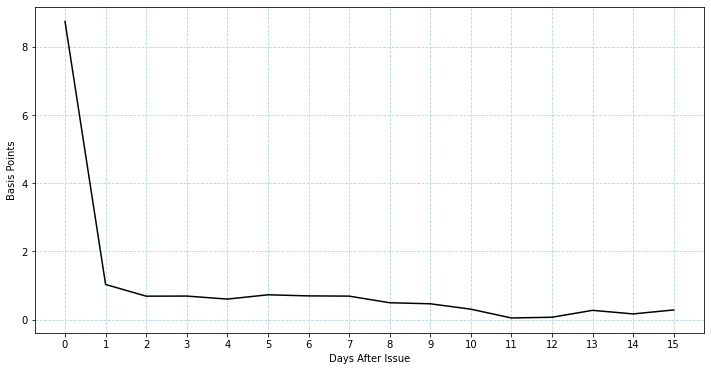

In [60]:
plt.figure(figsize=(12, 6)) 

plt.plot(average_concession_by_day['rank'], average_concession_by_day['concessionSpread'], color='black')  # Set line color to black
plt.xlabel('Days After Issue')
plt.ylabel('Basis Points')

plt.xticks(average_concession_by_day['rank']) 
plt.grid(True, linestyle='--', color='lightblue') 

# plt.savefig('price_convergence.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()